<a href="https://cognitiveclass.ai"><img src = "https://ibm.box.com/shared/static/9gegpsmnsoo25ikkbl4qzlvlyjbgxs5x.png" width = 400> </a>

# The Battle of the Neighborhoods - Week 2
# Applied Data Science Capstone Project

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1">Introduction<a name="introduction"></a></a></span><ul class="toc-item"><li><span><a href="#Background" data-toc-modified-id="Background-1.1">Background<a name="Background"></a></a></span></li><li><span><a href="#Problem-" data-toc-modified-id="Problem--1.2">Problem <a name="Problem"></a></a></span></li><li><span><a href="#Interest--" data-toc-modified-id="Interest---1.3">Interest  <a name="Interest"></a></a></span></li></ul></li><li><span><a href="#Data-" data-toc-modified-id="Data--2">Data <a name="data"></a></a></span></li></ul></div>

## Introduction<a name="introduction"></a>

### Background<a name="Background"></a>

The Corona Virus pandemic has had a devastating impact on the livelihoods of people and claimed lives all over the world. This project focuses on the spread of Covid-19 in New York City.New York is the most populous city in the United States, with an estimated 2019 population of 8,336,817 distributed over about 302.6 square miles (784 km2). New York City is also the most densely populated major city in the United States. New York City is widely considered the cultural, financial, and media capital of the world, significantly influencing commerce, entertainment, research, technology, education, politics, tourism, art, fashion, and sports in the United States and all over the world. Given its overall demographics, New York is one of the cities most susceptible to the rapid spread of Covid-19 globally. According to some studies, the most populous boroughs in New York City, Queens and Brooklyn, likely served as the major hubs of coronavirus disease (COVID-19) spread in the spring of 2020.

### Problem <a name="Problem"></a>

This study intends to assess the spread of COVID-19 in New York City across its neighborhoods. It has been argued that some of the most populous boroughs in New York City contributed significantly to the spread of COVID-19 at the onset of the pandemic. In this context, this project intends to cluster neighborhoods in New York City and map out venues in the specific clusters to see if there are any common feautures in the neighborhoods or clusters with high COVID-19 infections. The World Health Organisation notes that current evidence suggests that the virus spreads mainly between people who are in close contact with each other, and the virus can also spread in poorly ventilated and/or crowded indoor settings, where people tend to spend longer periods of time. In view of this, the initial thinking is that neighborhoods with a lot of restaurants, coffee shops and other venues where people crowd together are likely to have higher cummulative cases. In the end, the project considers choropleth maps showing COVID-19 red zones for neighborhoods in New York, and maps venues around centroids of calibrated clusters to assess the spread of COVID-19 based on venues associated with each cluster, as well as venues associated with each Borough.

### Interest  <a name="Interest"></a>

This study is most useful for Health Care Policy makers and Medical Practitioners looking to understand how venues might influence the spread of a disease like COVID-19 for future and current use. It might also be useful for individuals looking to protect themselves by understanding how frequenting certain venues might increase chances of infection. An understanding of such dynamics is vital for coming up with targetted policy measures for most vulnerable neighborhoods such as, providing necessary medical advice and assistance and enforcing movement restrictions.

## Data <a name="data"></a>

The project will utilise data outlined below:

i. Download New York City COVID-19 Data by ZIP Code from url:https://raw.githubusercontent.com/nychealth/coronavirus-data/master/totals/data-by-modzcta.csv

ii. Download New York neighborhood data from url: https://cocl.us/new_york_dataset (JSON file)

iii. Use Geolocator package to obtain coordinates of New York City and of neighborhoods in New York City

iv. I will use the following API:
* Foursquare API: to search venues around centroids for clustered neighborhoods in New York City and for each Borough.

FourSquare API will return lists of venues using the co-ordinates for the centroids of the clusters. It will also return the latitude and longitude for each venue.

The study uses the explore API call to identify venues within a walking distance, which is assumed to be 1 kilometre, from the center of each of the clusters.

Imports and Installations

In [684]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
#import folium
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values (OpenStreetMaps)
import requests
import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from bs4 import BeautifulSoup as bs
import folium

Define Foursquare Credentials and Version

In [685]:
CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare Secret
VERSION = '20210324' # Foursquare API version

Fetch New York Neighborhoods Data

In [686]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data


In [687]:
ny_neigh = get_new_york_data()
ny_neigh.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Define shape of the data obtained

In [688]:
ny_neigh.shape

(306, 4)

In [689]:
#Get Covid-19 Data for Zip Codes
ny_covid = pd.read_csv(r'https://raw.githubusercontent.com/nychealth/coronavirus-data/master/totals/data-by-modzcta.csv')
ny_covid.head()

,MODIFIED_ZCTA,NEIGHBORHOOD_NAME,BOROUGH_GROUP,label,lat,lon,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE,TOTAL_COVID_TESTS
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,"10001, 10118",40.750693,-73.997137,1638,5931.97,27613.09,35,126.75,7.10,23095
1,10002,Chinatown/Lower East Side,Manhattan,10002,40.715781,-73.986176,6128,8135.66,75322.71,289,383.68,11.81,52019
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,10003,40.731825,-73.989164,2937,5441.12,53977.81,49,90.78,6.73,43597
3,10004,Financial District,Manhattan,10004,40.703675,-74.013106,256,8613.39,2972.12,2,67.29,6.54,3928
4,10005,Financial District,Manhattan,10005,40.706092,-74.008861,433,4944.49,8757.23,0,0.00,6.28,6817


In [690]:
ny_covid.shape

(177, 13)

The data obtained using the New York JSON file containing neighborhoods does not have the same shape as the COVID-19 Cases data. Fortunately, the COVID-19 data also contains neighborhoods and Boroughs data to be able to do clustering and all the necessary analysis, even though it contains lesser number of neighborhoods. Therefore, the COVID-19 data for Zip Codes is used for further analysis.

In [691]:
ny_covid = ny_covid.rename(columns = {'MODIFIED_ZCTA': 'Zipcode','lat':'Latitude','lon':'Longitude',
                                      'BOROUGH_GROUP':'Borough','NEIGHBORHOOD_NAME':'Neighborhood',
                                      'COVID_CASE_RATE':'COVID_Cases'}, inplace = False)

In [692]:
ny_covid.drop(['label','COVID_CASE_COUNT','POP_DENOMINATOR',
               'COVID_DEATH_COUNT','COVID_DEATH_RATE','PERCENT_POSITIVE','TOTAL_COVID_TESTS'],
              axis='columns', inplace=True)

In [693]:
ny_covid.head()

,Zipcode,Neighborhood,Borough,Latitude,Longitude,COVID_Cases
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,40.750693,-73.997137,5931.97
1,10002,Chinatown/Lower East Side,Manhattan,40.715781,-73.986176,8135.66
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,40.731825,-73.989164,5441.12
3,10004,Financial District,Manhattan,40.703675,-74.013106,8613.39
4,10005,Financial District,Manhattan,40.706092,-74.008861,4944.49


In [694]:
ny_data = ny_covid
ny_data.head()

,Zipcode,Neighborhood,Borough,Latitude,Longitude,COVID_Cases
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,40.750693,-73.997137,5931.97
1,10002,Chinatown/Lower East Side,Manhattan,40.715781,-73.986176,8135.66
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,40.731825,-73.989164,5441.12
3,10004,Financial District,Manhattan,40.703675,-74.013106,8613.39
4,10005,Financial District,Manhattan,40.706092,-74.008861,4944.49


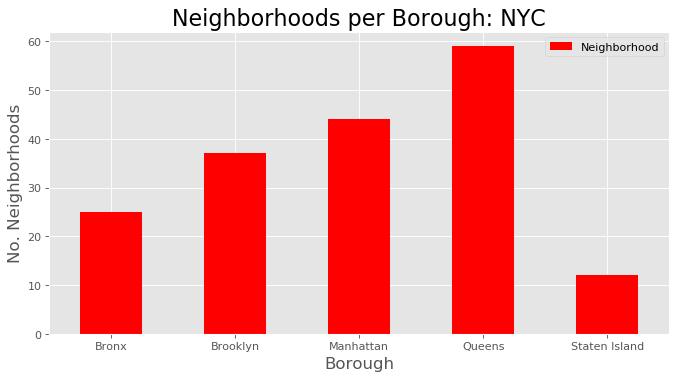

In [695]:
#Bar chart of Neighborhoods in New York City
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 80)
clr = "red"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [696]:
#Use geolocator to get coordinates of New York City
city = 'New York City, NY'

geolocator = Nominatim(user_agent="Coordinates")
location = geolocator.geocode(city)
latitude = location.latitude
longitude = location.longitude
print('Geograpical coordinates of New York City are {}, {}.'.format(latitude, longitude))

Geograpical coordinates of New York City are 40.7127281, -74.0060152.


In [701]:
#Group Covid-19 Data by Borough and compute total cases for each Borough
county = ny_covid.groupby('Borough')
county.sum()

,Zipcode,Latitude,Longitude,COVID_Cases
Borough,,,,
Bronx,261575,1021.236626,-1846.960862,257288.61
Brooklyn,415151,1504.153973,-2736.392527,320022.02
Manhattan,441720,1793.758626,-3254.825444,274395.60
Queens,671310,2402.241855,-4355.673519,564932.11
Staten Island,123681,487.031546,-889.776197,156713.97


In [702]:
#Sort Boroughs data by number of Covid Cases and drop summed geographical coordinates 
county = county.sum()
county.sort_values(['COVID_Cases'],ascending=False, inplace=True)
county.drop(['Zipcode','Latitude','Longitude'],axis='columns', inplace=True)
county

,COVID_Cases
Borough,
Queens,564932.11
Brooklyn,320022.02
Manhattan,274395.60
Bronx,257288.61
Staten Island,156713.97


In [703]:
#check index of the county dataframe
county.columns

Index(['COVID_Cases'], dtype='object')

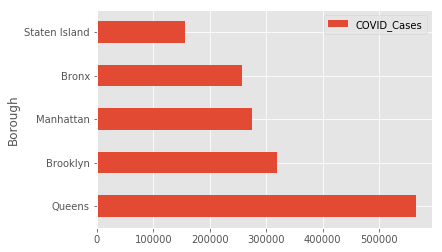

In [704]:
#plot barchart of county Covid cases
Chart = county.plot.barh()

Map Out Neighborhoods in New York before Clustering

In [705]:
neighborhoods = ny_data
#Create map of New York City using latitude and longitude values
map_nyc = folium.Map(location=[latitude, longitude], zoom_start=10.4)

# Add markers to map
for lat, lng, borough, neighbourhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_nyc)
    
map_nyc

In [706]:
#m = folium.Map(location=[latitude, longitude], zoom_start=10)

Cluster Neighborhoods

In [707]:
#use if need to run again with a different K
#ny_data.drop(['Cluster Labels'], axis=1, inplace=True)

In [708]:
#Compute clusters with K = 6 (number of Boroughs in the data)
k=6
nyc_clustering = ny_data.drop(['Zipcode','Borough','Neighborhood'],1)
kmeans = KMeans(n_clusters = k,random_state=0).fit(nyc_clustering)
kmeans.labels_
ny_data.insert(0, 'Cluster Labels', kmeans.labels_)

Obtaing Cluster Centers or Centroids for each cluster

In [709]:
#compute centroids
kmeans.cluster_centers_

array([[   40.74144384,   -73.86705302,  9359.6255814 ],
       [   40.74219064,   -73.92835204,  6367.7872    ],
       [   40.7425649 ,   -73.88495887, 11090.1945    ],
       [   40.60149525,   -74.05135925, 13414.234375  ],
       [   40.72505893,   -73.90833083,  8031.43466667],
       [   40.73510813,   -73.98549739,  4891.96347826]])

Convert cluster_centers array into a Pandas Dataframe

In [710]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=['latitude', 'longitude','COVID_Cases'])
centroids['Clusters'] = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6']
centroids

,latitude,longitude,COVID_Cases,Clusters
0,40.741444,-73.867053,9359.625581,Cluster 1
1,40.742191,-73.928352,6367.787200,Cluster 2
2,40.742565,-73.884959,11090.194500,Cluster 3
3,40.601495,-74.051359,13414.234375,Cluster 4
4,40.725059,-73.908331,8031.434667,Cluster 5
5,40.735108,-73.985497,4891.963478,Cluster 6


Create Clustered Map of Neighborhoods in New York City using Folium Library

In [711]:
# create map
map_clusters = folium.Map(location=[latitude, longitude],zoom_start=10)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighbourhood, cluster in zip(ny_data['Latitude'], ny_data['Longitude'], ny_data['Neighborhood'], ny_data['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Count Neighborhoods in Each Borough

Use Foursquare API to find popular venues around centroids of clusters

Analysis of First Cluster 

In [712]:
#map cluster 1 with nearby venues
cluster_1 = centroids.loc[0, 'Clusters']
latitude = centroids.loc[0, 'latitude'] 
longitude = centroids.loc[0, 'longitude'] 
# limit of number of venues returned by Foursquare API
LIMIT = 100 
radius = 1000

In [713]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
results = requests.get(url).json()

In [714]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)

In [715]:
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

In [716]:
venues_map = folium.Map(location=[latitude_1, longitude_1], zoom_start=15)
# add a red circle marker to represent Cluster 1
folium.features.CircleMarker(
    [latitude_1, longitude_1],
    radius=10,
    color='red',
    popup='Cluster 1',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)
# add all venues as blue circle markers
for lat, lng, label in zip(nearby_venues.lat, nearby_venues.lng, nearby_venues.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)
venues_map

In [717]:
#geographical coordinates of center of cluster 2
latitude = centroids.loc[1, 'latitude'] 
longitude= centroids.loc[1, 'longitude'] 
# limit of number of venues returned by Foursquare API
LIMIT = 100 
radius = 1000

In [718]:
#use FourSquare API to explore nearby venues
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
results = requests.get(url).json()

In [719]:
#nearby venues for center of cluster 2
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)

In [720]:
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

In [721]:
#map for center of cluster 2 with nearby venues
venues_map = folium.Map(location=[latitude, longitude], zoom_start=15)
# add a red circle marker to represent Cluster 1
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Cluster 2',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)
# add all venues as blue circle markers
for lat, lng, label in zip(nearby_venues.lat, nearby_venues.lng, nearby_venues.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)
venues_map

In [722]:
#geographical coordinates of center of cluster 3
cluster_3 = centroids.loc[2, 'Clusters']
latitude = centroids.loc[2, 'latitude'] 
longitude= centroids.loc[2, 'longitude'] 
# limit of number of venues returned by Foursquare API
LIMIT = 100 
radius = 1000

In [723]:
#use FourSquare API to explore nearby venues
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
results = requests.get(url).json()

In [724]:
#nearby venues for center of cluster 3
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)

In [725]:
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

In [726]:
#map for center of cluster 3 with nearby venues
venues_map = folium.Map(location=[latitude, longitude], zoom_start=15)
# add a red circle marker to represent Cluster 1
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Cluster 3',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)
# add all venues as blue circle markers
for lat, lng, label in zip(nearby_venues.lat, nearby_venues.lng, nearby_venues.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)
venues_map

In [727]:
cluster_4 = centroids.loc[3, 'Clusters']
latitude = centroids.loc[3, 'latitude'] 
longitude= centroids.loc[3, 'longitude'] 
# limit of number of venues returned by Foursquare API
LIMIT = 100 
radius = 1000

In [728]:
#use FourSquare API to explore nearby venues
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
results = requests.get(url).json()

In [729]:
#nearby venues for center of cluster 4
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)

In [730]:
 #filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

In [731]:
#map for center of cluster 4 with nearby venues
venues_map = folium.Map(location=[latitude, longitude], zoom_start=15)
# add a red circle marker to represent Cluster 1
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Cluster 4',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)
# add all venues as blue circle markers
for lat, lng, label in zip(nearby_venues.lat, nearby_venues.lng, nearby_venues.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)
venues_map

In [732]:
cluster_5 = centroids.loc[4, 'Clusters']
latitude = centroids.loc[4, 'latitude'] 
longitude= centroids.loc[4, 'longitude'] 
# limit of number of venues returned by Foursquare API
LIMIT = 100 
radius = 1000

In [733]:
#use FourSquare API to explore nearby venues
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
results = requests.get(url).json()

In [734]:
#nearby venues for center of cluster 5
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)

In [735]:
 #filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

In [736]:
#map for center of cluster 5 with nearby venues
venues_map = folium.Map(location=[latitude, longitude], zoom_start=15)
# add a red circle marker to represent Cluster 1
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Cluster 5',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)
# add all venues as blue circle markers
for lat, lng, label in zip(nearby_venues.lat, nearby_venues.lng, nearby_venues.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)
venues_map

In [737]:
#geographical coordinates of cluster 6
cluster_6 = centroids.loc[5, 'Clusters']
latitude = centroids.loc[5, 'latitude'] 
longitude= centroids.loc[5, 'longitude'] 
# limit of number of venues returned by Foursquare API
LIMIT = 100 
radius = 1000

In [738]:
#use FourSquare API to explore nearby venues
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
results = requests.get(url).json()

In [739]:
#nearby venues from center of cluster 6
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)

In [740]:
 #filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

In [741]:
#map for center of cluster 6 with nearby venues
venues_map = folium.Map(location=[latitude, longitude], zoom_start=15)
# add a red circle marker to represent Cluster 1
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Cluster 6',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)
# add all venues as blue circle markers
for lat, lng, label in zip(nearby_venues.lat, nearby_venues.lng, nearby_venues.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)
venues_map

Get Nearby Venues

In [742]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Clusters', 
                  'latitude', 
                  'longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [743]:
#use getNearbyVenues function to get venues nearby centroids of the clusters
nyc_venues = getNearbyVenues(names = centroids['Clusters'],
                                   latitudes = centroids['latitude'],
                                   longitudes = centroids['longitude']
                                  )
                                  
nyc_venues.head()

,Clusters,latitude,longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Cluster 1,40.741444,-73.867053,La Esquina Criolla,40.742153,-73.867526,Argentinian Restaurant
1,Cluster 1,40.741444,-73.867053,El Gauchito,40.742161,-73.868087,Argentinian Restaurant
2,Cluster 1,40.741444,-73.867053,Leo's Latticini,40.746219,-73.859809,Deli / Bodega
3,Cluster 1,40.741444,-73.867053,Disney Store,40.734885,-73.868538,Toy / Game Store
4,Cluster 1,40.741444,-73.867053,SEPHORA,40.734622,-73.870038,Cosmetics Shop


In [744]:
#group venues by clusters and count them
nyc_venues.groupby('Clusters').count()

,latitude,longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Clusters,,,,,,
Cluster 1,100,100,100,100,100,100
Cluster 2,100,100,100,100,100,100
Cluster 3,100,100,100,100,100,100
Cluster 4,9,9,9,9,9,9
Cluster 5,35,35,35,35,35,35
Cluster 6,100,100,100,100,100,100


In [745]:
print('There are {} unique categories.'.format(len(nyc_venues['Venue Category'].unique())))

There are 156 unique categories.


In [746]:
# one hot encoding
ny_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix = "", prefix_sep = "")

# add neighborhood column back to dataframe
ny_onehot['Clusters'] = nyc_venues['Clusters'] 

# move neighborhood column to the first column
fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[fixed_columns]

ny_onehot.head()

,Clusters,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beer Bar,Big Box Store,Bistro,Bookstore,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Stop,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Colombian Restaurant,Comic Shop,Cosmetics Shop,Cuban Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Electronics Store,Empanada Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,Gift Shop,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Health Food Store,Himalayan Restaurant,Historic Site,Home Service,Hotel,Ice Cream Shop,Indian Restaurant,Indie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Latin American Restaurant,Lighthouse,Lingerie Store,Liquor Store,Malay Restaurant,Martial Arts School,Mattress Store,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Moving Target,Nail Salon,New American Restaurant,North Indian Restaurant,Office,Outdoor Sculpture,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Pub,Ramen Restaurant,Rental Car Location,Restaurant,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Skating Rink,Snack Place,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Tourist Information Center,Toy / Game Store,Turkish Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Cluster 1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Cluster 1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Cluster 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Cluster 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Cluster 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [747]:
#group venues by clusters after one-hote encoding
ny_grouped = ny_onehot.groupby('Clusters').mean().reset_index()
ny_grouped.head()

,Clusters,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beer Bar,Big Box Store,Bistro,Bookstore,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Stop,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Colombian Restaurant,Comic Shop,Cosmetics Shop,Cuban Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Electronics Store,Empanada Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,Gift Shop,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Health Food Store,Himalayan Restaurant,Historic Site,Home Service,Hotel,Ice Cream Shop,Indian Restaurant,Indie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Latin American Restaurant,Lighthouse,Lingerie Store,Liquor Store,Malay Restaurant,Martial Arts School,Mattress Store,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Moving Target,Nail Salon,New American Restaurant,North Indian Restaurant,Office,Outdoor Sculpture,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Pub,Ramen Restaurant,Rental Car Location,Restaurant,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Skating Rink,Snack Place,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Tourist Information Center,Toy / Game Store,Turkish Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Cluster 1,0.01,0.00,0.03,0.0,0.00,0.00,0.00,0.0,0.000000,0.000000,0.00,0.030000,0.010000,0.000000,0.000000,0.0,0.01,0.00,0.0,0.00,0.02,0.01,0.01,0.000000,0.00,0.00,0.00,0.0,0.00,0.01,0.04,0.00,0.050000,0.00,0.0,0.04,0.01,0.0,0.010000,0.02,0.010000,0.020000,0.00,0.00,0.00,0.020000,0.00,0.01,0.01,0.00,0.03,0.00,0.000000,0.0,0.00,0.010000,0.02,0.01,0.01,0.000000,0.00,0.00,0.01,0.0,0.000000,0.0,0.010000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.030000,0.00,0.0,0.02,0.01,0.02,0.00,0.00,0.01,0.000000,0.02,0.01,0.00,0.0,0.00,0.0,0.06,0.00,0.03,0.000000,0.00,0.0,0.00,0.0,0.0,0.01,0.000000,0.00,0.010000,0.01,0.030000,0.040000,0.000000,0.00,0.00,0.00,0.0,0.0,0.0,0.02,0.01,0.0,0.00,0.00,0.00,0.02,0.01,0.00,0.02,0.0,0.03,0.00,0.01,0.0,0.00,0.00,0.0,0.01,0.01,0.02,0.010000,0.00,0.01,0.00,0.00,0.0,0.01,0.00,0.00,0.000000,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.000000,0.0,0.0
1,Cluster 2,0.00,0.00,0.00,0.0,0.01,0.01,0.01,0.0,0.000000,0.000000,0.00,0.050000,0.000000,0.050000,0.000000,0.0,0.00,0.01,0.0,0.01,0.01,0.00,0.00,0.000000,0.00,0.00,0.01,0.0,0.03,0.00,0.01,0.00,0.040000,0.00,0.0,0.00,0.00,0.0,0.020000,0.00,0.000000,0.020000,0.02,0.01,0.01,0.050000,0.00,0.00,0.00,0.01,0.01,0.00,0.010000,0.0,0.00,0.000000,0.00,0.00,0.00,0.000000,0.02,0.00,0.00,0.0,0.000000,0.0,0.030000,0.01,0.01,0.01,0.01,0.00,0.000000,0.000000,0.010000,0.000000,0.01,0.0,0.00,0.01,0.02,0.01,0.01,0.00,0.000000,0.00,0.01,0.00,0.0,0.01,0.0,0.04,0.01,0.00,0.000000,0.01,0.0,0.01,0.0,0.0,0.00,0.010000,0.01,0.020000,0.00,0.000000,0.060000,0.010000,0.01,0.02,0.01,0.0,0.0,0.0,0.00,0.01,0.0,0.01,0.01,0.00,0.00,0.00,0.01

In [748]:
#define function for finding most common venues in each cluster
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [749]:
#find top 10 most common venues around each centroid
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Clusters']
for ind in np.arange(num_top_venues):
    try:
        # append 'st', 'nd', 'rd' to the top 3 venues
        columns.append('{}{} Most Common Venue'.format(ind + 1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind + 1))

# create a new dataframe
cluster_venues_sorted = pd.DataFrame(columns = columns)
cluster_venues_sorted['Clusters'] = ny_grouped['Clusters']

for ind in np.arange(ny_grouped.shape[0]):
    cluster_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ny_grouped.iloc[ind, :], num_top_venues)

cluster_venues_sorted

,Clusters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Cluster 1,Mexican Restaurant,Coffee Shop,Cosmetics Shop,Pizza Place,Clothing Store,Mobile Phone Shop,Argentinian Restaurant,Bakery,Pharmacy,South American Restaurant
1,Cluster 2,Pizza Place,Bar,Donut Shop,Bakery,Mexican Restaurant,Coffee Shop,Grocery Store,Chinese Restaurant,Discount Store,Deli / Bodega
2,Cluster 3,Thai Restaurant,Mexican Restaurant,Food Truck,Indian Restaurant,South American Restaurant,Vietnamese Restaurant,Bakery,Grocery Store,Filipino Restaurant,Indonesian Restaurant
3,Cluster 4,Park,Hotel,Lighthouse,Bus Stop,Government Building,Food Truck,Tourist Information Center,Historic Site,Donut Shop,Dog Run
4,Cluster 5,Deli / Bodega,Pizza Place,Bakery,Grocery Store,Donut Shop,Pharmacy,Pub,Home Service,Peruvian Restaurant,Park
5,Cluster 6,Mediterranean Restaurant,Italian Restaurant,Juice Bar,Coffee Shop,Park,Pizza Place,Cosmetics Shop,American Restaurant,Grocery Store,Gourmet Shop


In [751]:
#sort top 10 venues dataframe by COVID cases for each cluster
cluster_venues_sorted.sort_values(['COVID_Cases'],ascending=False, inplace=True)
cluster_venues_sorted

,Clusters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,COVID_Cases
3,Cluster 4,Park,Hotel,Lighthouse,Bus Stop,Government Building,Food Truck,Tourist Information Center,Historic Site,Donut Shop,Dog Run,13414.234375
2,Cluster 3,Thai Restaurant,Mexican Restaurant,Food Truck,Indian Restaurant,South American Restaurant,Vietnamese Restaurant,Bakery,Grocery Store,Filipino Restaurant,Indonesian Restaurant,11090.194500
0,Cluster 1,Mexican Restaurant,Coffee Shop,Cosmetics Shop,Pizza Place,Clothing Store,Mobile Phone Shop,Argentinian Restaurant,Bakery,Pharmacy,South American Restaurant,9359.625581
4,Cluster 5,Deli / Bodega,Pizza Place,Bakery,Grocery Store,Donut Shop,Pharmacy,Pub,Home Service,Peruvian Restaurant,Park,8031.434667
1,Cluster 2,Pizza Place,Bar,Donut Shop,Bakery,Mexican Restaurant,Coffee Shop,Grocery Store,Chinese Restaurant,Discount Store,Deli / Bodega,6367.787200
5,Cluster 6,Mediterranean Restaurant,Italian Restaurant,Juice Bar,Coffee Shop,Park,Pizza Place,Cosmetics Shop,American Restaurant,Grocery Store,Gourmet Shop,4891.963478


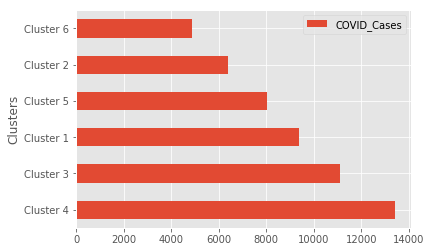

In [752]:
#plot barchart of COVID cases corresponding to each centroid
ax = cluster_venues_sorted.plot.barh(x='Clusters', y='COVID_Cases', rot=0)